# Data Challenge: Node Classification for Greek websites
## Part: Data Preparation & Exploration

<br />
<div style="text-align: left"> <b> Date: </b> June 2024 </div>

---

> Didimiotou-Kaoukaki Konstantina, ID: p3352206 <br />
> Kortsinoglou Eirini, ID: p3352212 <br />
> Fountas Dimitrios, ID: p3352228 <br />

> MSc in Data Science (PT) <br />
> Department of Informatics <br />
> Athens University of Economics and Business <br />

In [19]:
import os
import re
import csv

import pickle
import spacy
import unicodedata
import zipfile
import numpy as np
import pandas as pd

from tqdm import tqdm
from io import BytesIO

from spacy.tokenizer import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
from transformers import AutoTokenizer, AutoModel
import networkx as nx
import community
import matplotlib.pyplot as plt
from collections import Counter


### Data loading

The function reads the training data from train.txt, storing domain names and labels in train_domains and y_train lists. It then reads test data from test.txt, storing domain names in the test_domains list.

Finally, it extracts textual content from domains.zip, storing the content in a dictionary text with domain names as keys.

In [2]:
# Read training data
train_domains = list()
y_train = list()
with open("train.txt", 'r') as f:
    for line in tqdm(f):
        l = line.split(',')
        train_domains.append(l[0])
        y_train.append(l[1][:-1])

# Read test data
test_domains = list()
with open("test.txt", 'r') as f:
    for line in tqdm(f):
        l = line.split(',')
        test_domains.append(l[0])

# Read textual content of webpages of domain names
text = dict()
with zipfile.ZipFile('domains.zip', "r") as zfile:
    for filename in tqdm(zfile.namelist()):
        if re.search(r'\.zip$', filename) is not None:
            zfiledata = BytesIO(zfile.read(filename))
            with zipfile.ZipFile(zfiledata) as zfile2:
                text[filename[:-4]] = ''
                for name2 in zfile2.namelist():
                    file = zfile2.read(name2)
                    text[filename[:-4]] += file.decode('utf16') + ' '
                    

1812it [00:00, 302731.68it/s]
605it [00:00, 304518.65it/s]
100%|███████████████████████████████████████████████████████████████████████████| 40600/40600 [00:51<00:00, 789.24it/s]


In [3]:
# Create a directed graph
G = nx.read_edgelist('edgelist.txt', delimiter=' ', create_using=nx.DiGraph())

print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

avg_neig_deg = nx.average_neighbor_degree(G, nodes=train_domains)

Number of nodes: 65208
Number of edges: 1642073


## Data preprocessing

This function below keeps the domains that appear in the train and text files and retrieves their corresponding textual content from the text dictionary. If a domain's content is not found, it appends an empty string.

In [4]:
# Retrieve textual content of domain names of the training and test sets
in_scope_domains = train_domains + test_domains
in_scope_text_data = list()
for domain in in_scope_domains:
    if domain in text:
        in_scope_text_data.append(text[domain])
    else:
        in_scope_text_data.append('')

# To reduce memory 
text = None

In order to reduce the text size, we truncate all texts up until the average length of the texts, which is approximately 10K. This is performed below in function *truncate_text()*, which limits the length of text to the specified number of words.

In [5]:
# Calculate average text length in words
lengths = [len(text.split()) for text in in_scope_text_data]
average_length = sum(lengths) // len(lengths)
print("The average length of the html texts is: ", average_length)

The average length of the html texts is:  10095


In [6]:
# Truncate texts to the defined upper limit
def truncate_text(text, upper_limit):
    words = text.split()
    truncated_text = " ".join(words[:upper_limit])
    return truncated_text


truncated_text = {site: truncate_text(text, average_length) for site, text in zip(in_scope_domains, in_scope_text_data)}

In [7]:
# Save preprocessed data to a pickle file
with open('text_trunc_data.pkl', 'wb') as f:
    pickle.dump(truncated_text, f)

After truncating the data, we define the function *preprocess_text()* for text preprocessing. Within this function, we remove newline characters, URLs, accents, and convert text to lowercase. It then tokenizes and lemmatizes the text using spaCy, removing symbols, stopwords, and words with fewer than three characters, which might not be informative. 

In [8]:
# Load spaCy Greek model
nlp = spacy.load("el_core_news_sm")

# Preprocess texts with spaCy
def preprocess_text(text):
    
    # Remove newline characters
    text = text.replace('\n', ' ')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove accents and convert to lower case all
    text_new = ''.join(c for c in unicodedata.normalize('NFD', text)
                  if unicodedata.category(c) != 'Mn').lower()
    
    doc = nlp(text_new)
    processed_tokens = []

    for token in doc:
        # Lowercase and lemmatize
        lemma = token.lemma_
        # Remove symbols, stopwords, and words with less than 3 characters
        if lemma.isalpha() and len(lemma) >= 3 and not token.is_stop:
            processed_tokens.append(lemma)
    return " ".join(processed_tokens)

# Initialize tqdm progress bar
preproc_data = {}
for site, text in tqdm(truncated_text.items(), desc="Processing", unit="text"): 
    preproc_data[site] = preprocess_text(text)

Processing: 100%|████████████████████████████████████████████████████████████████| 2417/2417 [29:52<00:00,  1.35text/s]


In [9]:
# Retrieve textual content (reduced) of domain names of the training & test set
train_text_data = list()
for domain in train_domains:
    train_text_data.append(preproc_data[domain])

test_text_data = list()
for domain in test_domains:
    test_text_data.append(preproc_data[domain])

# To reduce memory 
trunc_data = None
preproc_data = None

In [10]:
len(train_domains)

1812

In [12]:
with open('train_text_data.pkl', 'wb') as f:
    pickle.dump(train_text_data, f)
    
with open('test_text_data.pkl', 'wb') as f:
    pickle.dump(test_text_data, f)

In [13]:
# mapper = test_text_data.to_dict()['Text']
class_mapper_df = pd.DataFrame(y_train, train_domains).reset_index()
class_mapper_df.columns = ["Domain","Class"]
class_mapper_df["Text"] = train_text_data
# find in-degree, out-degree and avg neighbors degree for each domain node in the train set 
class_mapper_df['in_degree'] = class_mapper_df['Domain'].apply(lambda x: G.in_degree(x))
class_mapper_df['out_degree'] = class_mapper_df['Domain'].apply(lambda x: G.out_degree(x))
class_mapper_df['avg_neighbor_degree'] = class_mapper_df['Domain'].apply(lambda x: avg_neig_deg[x])

In [14]:
class_mapper_df.head()

,Domain,Class,Text,in_degree,out_degree,avg_neighbor_degree
0,autocarnet.gr,0,συμπληρωστε ερωτηματολογιο αξιοπιστιος αυτοκιν...,84,429,161.673660
1,queen.gr,5,νικολεττα ραλλης μεταφερω εμπειρια απο φωτογρα...,986,253,27.509881
2,aggeliorama.gr,5,εξοπλισμος επιχειρησεων πατρας αχαιο ελλαδα πω...,17,15,149.733333
3,bikerspoint.gr,0,προτεινετε εναν φιλο ζελατινο καλαθι εχω κανεν...,14,5,24.800000
4,athensgo.gr,3,γυναικας ψηφισαν αυτα ειμαι σημεια οποιος λατρ...,19,127,113.039370


## Data exploration

In [15]:
def class_exploration(class_mapper_df):
    
    # Plot class distribution in train set 
    classes_series = class_mapper_df.groupby('Class').Domain.count()
    
    plt.figure(figsize=(8, 6))
    classes_series.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Classes on the Train Set')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation = 45)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout()
    plt.show()
    
    # Print 10 domain names per class 
    # Group by 'Class' and get unique 'Domain' arrays
    grouped_domains = class_mapper_df.groupby('Class')['Domain'].unique()
    
    # Extract the first 10 domains from each class
    first_domains = grouped_domains.apply(lambda x: x[:10])
    first_domains_df = first_domains.apply(pd.Series).reset_index()

    # Rename the columns 
    column_names = ['Class'] + [f'Domain_{i+1}' for i in range(10)]
    first_domains_df.columns = column_names
    first_domains_df.drop('Class',axis =1,inplace = True)
    
    # find top 10 most common words from the texts of each class 
    top_words = {}
    for class_label, group in class_mapper_df.groupby('Class'):
        all_text = ' '.join(group['Text'])
        tokens = all_text.split()
        word_counts = Counter(tokens)
        top_words[class_label] = [(word,count) for word, count in word_counts.items() if len(word) >= 10][:20]
    
    # find avg degrees per class
    
    avg_deg = class_mapper_df.groupby('Class').agg({'in_degree': ['mean'], 
                                                    'out_degree': ['mean']})
    avg_deg.columns = avg_deg.columns.droplevel()
    avg_deg.columns = ['mean_in','mean_out']
    
    # find domains per class with highest in degrees: most popular sites 
    
    max_deg = class_mapper_df.groupby('Class').in_degree.max().reset_index()
    joined_max = class_mapper_df.merge(max_deg, on ='Class', how = 'left')
    joined_max_in = joined_max[joined_max.in_degree_x == joined_max.in_degree_y][['Domain','Class','in_degree_x']]
    
    # find domains with highest out links: many references
    
    max_deg = class_mapper_df.groupby('Class').out_degree.max().reset_index()
    joined_max = class_mapper_df.merge(max_deg, on ='Class', how = 'left')
    joined_max_out = joined_max[joined_max.out_degree_x == joined_max.out_degree_y][['Domain','Class','out_degree_x']]
    
    # find domains with highest avg neighbors degrees: point to popular domains
    
    max_deg = class_mapper_df.groupby('Class').avg_neighbor_degree.max().reset_index()
    joined_max = class_mapper_df.merge(max_deg, on ='Class', how = 'left')
    joined_max_neig = joined_max[joined_max.avg_neighbor_degree_x == joined_max.avg_neighbor_degree_y][['Domain','Class','avg_neighbor_degree_x']]
      
    
    
    return first_domains_df, top_words, avg_deg, joined_max_in, joined_max_out, joined_max_neig

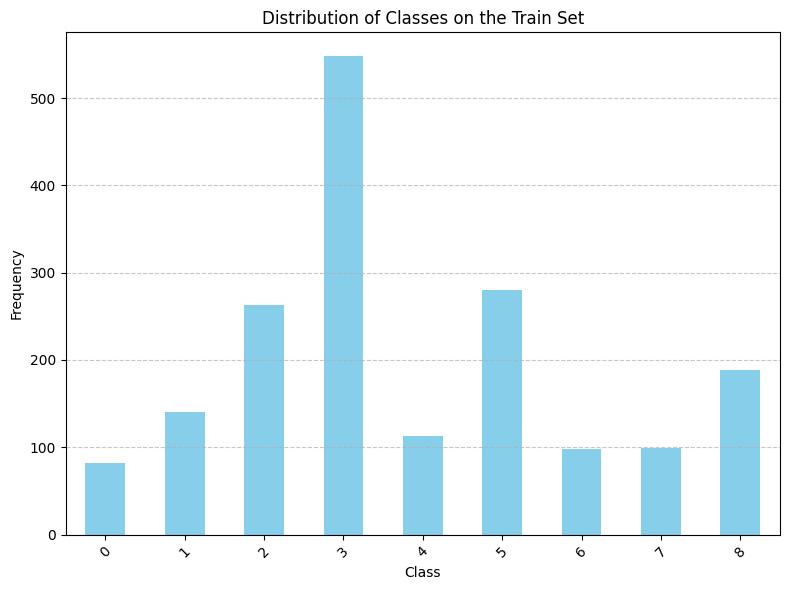

Indicative domains per each Class


,Domain_1,Domain_2,Domain_3,Domain_4,Domain_5,Domain_6,Domain_7,Domain_8,Domain_9,Domain_10
0,autocarnet.gr,bikerspoint.gr,mydirect.gr,f1fan.gr,asfalistra.gr,dim-tires.gr,mini.com.gr,citroen.gr,caranddriver.gr,moto-plus.gr
1,coachbasketball.gr,basketplus.gr,sportdepot.gr,velocitybikes.gr,cosmossport.gr,bianchi.gr,koe.org.gr,athlitiko.gr,redvoice.gr,sporfm.gr
2,yourate.gr,theacropolismuseum.gr,rockandroll.gr,guestlist.gr,naftotopos.gr,rythmosweb.gr,the-walking-dead-greek-fanatics.gr,wehellas.gr,disney.gr,tsekouratoi.gr
3,athensgo.gr,kafeneio-gr.blogspot.gr,onalert.gr,mykosmos.gr,kriti24.gr,tribune.gr,rthess.gr,verena.gr,rednotebook.gr,makeleio.gr
4,oaed.gr,education.gr,livepedia.gr,paideia-ergasia.gr,pi-schools.gr,csap.gr,jobstoday.gr,paster.gr,unipi.gr,pliroforikiatschool.blogspot.gr
5,queen.gr,aggeliorama.gr,kraxtis-gr.blogspot.gr,hostplus.gr,pixeldraw.gr,solygeia.blogspot.gr,specialone.gr,e-kalithea.gr,cyta.com.gr,aboutnet.gr
6,topgamos.gr,spitistalefka.gr,psistis.gr,flexystrom.gr,decofairy.gr,all4mama.gr,koykoycook.gr,livewall.gr,arttable.gr,epiplo-telioridis.gr
7,disaki.blogspot.gr,holiday.gr,yahotels.gr,gtp.gr,money-tourism.blogspot.gr,europe-hotels.gr,samothraki.gr,mega-holidays.gr,lefkada-ionio.gr,pamediakopes.gr
8,angelopouloshair.gr,sweetandbalance.gr,psychologos-vasilikiliafou.gr,healingeffect.blogspot.gr,psychotherapeia.net.gr,ladyslife.gr,diaitologia.blogspot.gr,anassa.gr,ygeianet.gov.gr,dhi.gr


Class 0 - Top 20 words: ['συμπληρωστε', 'ερωτηματολογιο', 'αξιοπιστιος', 'αυτοκινητου', 'παραδοθηκε', 'κυκλοφορια', 'παραδεισιος', 'αυτοκινητοδρομου', 'ταλαιπωρια', 'μετακινουνταν', 'παραδεισιων', 'κατασκευηςς', 'παραδεισια', 'αποδιδονται', 'ανισοπεδος', 'κυπαρισσιας', 'κυπαρισσια', 'κατασκευαστηκαν', 'παραχωρηση', 'περιφερεια']
Class 1 - Top 20 words: ['παιδαγωγικος', 'παιδαγωγικη', 'προερχεται', 'παιδαγωγος', 'ακριβολογωντα', 'εκπαιδευτικος', 'χρησιμοποιειται', 'περιγραψει', 'επεξηγησει', 'προπονητος', 'διδασκαλια', 'γενικοτερα', 'πραγματευω', 'θεμελιωδεις', 'προπονητικος', 'διδασκαλιο', 'διαδικασια', 'προπονητης', 'μεγαλυτερη', 'ολοκληρωνω']
Class 2 - Top 20 words: ['κατεβαζοντα', 'χρειαζεται', 'προσαρμοστω', 'τηλεοπτικο', 'εκπληκτικος', 'διευθυντος', 'φωτογραφια', 'χρησιμοποιει', 'υπερρεαλιστικα', 'εναρκτηριος', 'απεικονιση', 'δυσαναλογου', 'διακυβευμα', 'δυνατοτητης', 'παρακολουθησεις', 'ξεδιπλωνεται', 'εξαιρετικα', 'μακιαβελικο', 'αντεργουντ', 'υπολογισμενου']
Class 3 - Top 20 wo

,Domain,Class,in_degree_x
1653,car.gr,0,515
282,gazzetta.gr,1,2017
617,sansimera.gr,2,3069
1785,tovima.gr,3,6340
619,uoa.gr,4,3693
768,google.gr,5,7885
248,mothersblog.gr,6,694
1007,oasa.gr,7,823
310,iatronet.gr,8,1491


The domains per class with the highest out-degrees:


,Domain,Class,out_degree_x
1422,moto.gr,0,442
490,podilates.gr,1,1976
1486,slang.gr,2,1475
774,in2life.gr,3,3435
1368,apn.gr,3,3435
261,auth.gr,4,1334
482,freestuff.gr,5,3519
1630,hamomilaki.blogspot.gr,6,2102
528,arttravel.gr,7,848
570,iator.gr,8,564


The domains per class with the highest average neighbors degrees:


,Domain,Class,avg_neighbor_degree_x
1528,kokkinakis-service.gr,0,477.428571
911,sportcyclades.gr,1,278.432432
1686,sfgame.gr,2,1760.400000
1281,kalamatajournal.gr,3,1248.800000
1676,epimorphosi.gr,4,790.454545
1147,pitsirikos.gr,5,957.000000
1317,koykoycook.blogspot.gr,6,692.200000
508,rexhotelthessaloniki.gr,7,2159.000000
627,logosglyfadas.gr,8,2159.000000
1286,physio-activity.gr,8,2159.000000


In [20]:
first_domains_df, top_words,avg_deg, joined_max_in, joined_max_out, joined_max_neig  = class_exploration(class_mapper_df)
print("=======================================================================================================")
print("Indicative domains per each Class")
display(first_domains_df)
print("=======================================================================================================")
# Print the top 20 words for each class
for class_label, words in top_words.items():
    
    print(f"Class {class_label} - Top {len(words)} words:", end=" ")
    print([word for word, _ in words])
    print("=======================================================================================================")
    
print("The domains per class with the highest in-degrees:")
display(joined_max_in.sort_values(by ='Class'))
print("The domains per class with the highest out-degrees:")
display(joined_max_out.sort_values(by ='Class'))
print("The domains per class with the highest average neighbors degrees:")
display(joined_max_neig.sort_values(by ='Class'))

From the above analysis and by manually observing the texts per Class, we can map each Class to a specific theme:
* The **Zero Class** Represents **Driving** Based Content.
* The **First Class** Represents **Sports** Based Content.
* The **Second Class** Represents **Art** Based Content.
* The **Third Class** Represents **News** Based Content.
* The **Fourth Class** Represents **Education** Based Content.
* The **Fifth Class** Represents **Weather Forecasting, Customer Reviews and Online Transactions** Based Content.
* The **Sixth Class** Represents **Housing and Homeware** Based Content.
* The **Seventh Class** Represents **Traveling** Based Content.
* The **Eighth Class** Represents **Health** Based Content.

We then proceed by analyzing the graph data and we check the communities that are present in each class. Specifically, the function below performs community detection for each class in the dataset, using the Louvain method.  
It returns a dictionary where keys represent class labels and values are the community assignments for nodes within each class. Each node (domain) is assigned to a specific community within its respective class.

In [21]:
def community_detection_per_class(data, G, class_column='Class', node_column='Domain'):
    class_communities = {}

    # Iterate over each class
    for class_label, class_data in data.groupby(class_column):

        # Perform community detection using the Louvain method
        partition = community.best_partition(G.to_undirected())

        # Store the communities for the current class
        class_communities[class_label] = partition

    return class_communities

class_communities = community_detection_per_class(class_mapper_df,G)

In [23]:
# keep train domains only 
def filter_dictionary_by_domain_names(input_dict, domain_column):
    valid_domains = set(domain_column)
    filtered_dict = {key: {domain: value for domain, value in value_dict.items() if domain in valid_domains} for key, value_dict in input_dict.items()}
    return filtered_dict

filtered_communities = filter_dictionary_by_domain_names(class_communities, class_mapper_df['Domain'])

In [24]:
# Find the number of communities per class
community_counts = {}
for class_label, communities in filtered_communities.items():
    # Count the number of unique communities
    unique_communities = len(set(communities.values()))
    community_counts[class_label] = unique_communities

for class_label, count in community_counts.items():
    print(f"Class {class_label} has {count} communities.")

Class 0 has 9 communities.
Class 1 has 10 communities.
Class 2 has 10 communities.
Class 3 has 9 communities.
Class 4 has 9 communities.
Class 5 has 7 communities.
Class 6 has 8 communities.
Class 7 has 9 communities.
Class 8 has 8 communities.


In [25]:
def count_nodes_and_edges_per_community(class_communities, class_mapper_df,G):
    node_count_per_community = {}
    edge_count_per_community = {}

    # Iterate over each class
    for class_label, communities in class_communities.items():
        class_data = class_mapper_df[class_mapper_df['Class'] == class_label]

        # Calculate node count and edge count for each community
        node_count_per_community[class_label] = {}
        edge_count_per_community[class_label] = {}
        
        for community_id in set(communities.values()):
            community_nodes = [node for node, community in communities.items() if community == community_id]
            community_subgraph = G.subgraph(community_nodes)
            node_count = len(community_subgraph.nodes())
            edge_count = len(community_subgraph.edges())
            node_count_per_community[class_label][community_id] = node_count
            edge_count_per_community[class_label][community_id] = edge_count

    return node_count_per_community, edge_count_per_community

node_count_per_community, edge_count_per_community = count_nodes_and_edges_per_community(filtered_communities, class_mapper_df,G)

In [201]:
# Print the node count and edge count per community for each class

for class_label, communities in node_count_per_community.items():
    print(f"Node count and edge count per community for class {class_label}:")
    for community_id, node_count in communities.items():
        edge_count = edge_count_per_community[class_label][community_id]
        print(f"Community {community_id}: Node count = {node_count}, Edge count = {edge_count}")

Node count and edge count per community for class 0:
Community 0: Node count = 1, Edge count = 0
Community 1: Node count = 414, Edge count = 13203
Community 2: Node count = 554, Edge count = 1887
Community 3: Node count = 186, Edge count = 2317
Community 4: Node count = 440, Edge count = 5060
Community 5: Node count = 146, Edge count = 854
Community 6: Node count = 16, Edge count = 27
Community 7: Node count = 5, Edge count = 1
Community 8: Node count = 36, Edge count = 125
Community 9: Node count = 14, Edge count = 13
Node count and edge count per community for class 1:
Community 0: Node count = 62, Edge count = 475
Community 1: Node count = 659, Edge count = 19457
Community 2: Node count = 579, Edge count = 1993
Community 3: Node count = 145, Edge count = 563
Community 4: Node count = 15, Edge count = 35
Community 5: Node count = 133, Edge count = 1807
Community 6: Node count = 126, Edge count = 681
Community 7: Node count = 31, Edge count = 111
Community 8: Node count = 35, Edge cou

Finally, we print some useful statistics in the train and the text sets of textual representations.

In [26]:
def calculate_statistics(train_set, test_set,df):
    
    # Calculate average document length
    train_doc_lengths = [len(doc.split()) for doc in train_set]
    test_doc_lengths = [len(doc.split()) for doc in test_set]

    avg_doc_length_train = np.mean(train_doc_lengths)
    avg_doc_length_test = np.mean(test_doc_lengths)

    # Define a count vectorizer to define the vocabulary
    cv = CountVectorizer()

    # Calculate vocabulary size
    cov = cv.fit_transform(train_set)
    vocab_size_train =len(cv.vocabulary_)

    # Test tokens
    test_words = [word for doc in test_set for word in doc.split(' ')]

    # Find out-of-vocabulary words in the test set
    oov_words_test = set(test_words) - set(cv.vocabulary_.keys())
    
    # Find average document length per class 
    avg_doc_length = []
    grouped_by_class = df.groupby('Class')
    for class_label, group in grouped_by_class:
        # Calculate average document length
        doc_lengths = [len(doc.split()) for doc in group['Text']]
        avg_doc_length.append(np.mean(doc_lengths))
        
    return avg_doc_length_train, avg_doc_length_test, vocab_size_train, oov_words_test, avg_doc_length

In [27]:
avg_doc_len_train, avg_doc_len_test, vocab_s_train, oov_words, avg_doc_length = calculate_statistics(train_text_data, test_text_data,class_mapper_df)

print(f'Size of train set: {len(train_text_data)}')
print(f'Size of test set: {len(test_text_data)}')
print(f'Avg document length (train): {round(avg_doc_len_train)}')
print(f'Avg document length (test): {round(avg_doc_len_test)}')
print(f'Vocabulary size: {vocab_s_train}')
print(f'Out of vocabulary words (test): {len(oov_words)}')
print("===================================================================================================================")
print("Average Document Length per Class:")
for class_label, len_doc in enumerate(avg_doc_length):
    print(f"Class {class_label} - Avg doc length {int(len_doc)}")

Size of train set: 1812
Size of test set: 605
Avg document length (train): 3001
Avg document length (test): 2939
Vocabulary size: 195946
Out of vocabulary words (test): 30428
Average Document Length per Class:
Class 0 - Avg doc length 2079
Class 1 - Avg doc length 3256
Class 2 - Avg doc length 3062
Class 3 - Avg doc length 3813
Class 4 - Avg doc length 2503
Class 5 - Avg doc length 2408
Class 6 - Avg doc length 2715
Class 7 - Avg doc length 1992
Class 8 - Avg doc length 2616
